In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost
from utils import get_data, amex_metric
import ipywidgets


plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [2]:
CFG = {
    'num_folds': 5,

    'catboost': {
        'depth': 6,
        'iterations': 4000,
        'learning_rate': 0.04,
    },

    'seed': 777
}

In [3]:
train_data, target, cat_features = get_data('data/train_data.ftr', train=True)

/Users/dmitrykutsenko/Desktop/My_python/Kaggle_amex/utils.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['month'] = (data['date'].dt.year - 2017)*12+data['date'].dt.month
/Users/dmitrykutsenko/Desktop/My_python/Kaggle_amex/utils.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['rank'] = data.groupby('customer_ID')['month'].rank(ascending=False)


In [6]:
model = CatBoostClassifier(
    depth=CFG['catboost']['depth'],
    iterations=2000,
    #learning_rate=CFG['catboost']['learning_rate'],
    custom_metric='AUC',
    random_seed=CFG['seed'],
    thread_count=6,
    early_stopping_rounds=300
)
model.fit(Pool(train_data, target, cat_features=cat_features), verbose=100)

Learning rate set to 0.074722
0:	learn: 0.6037132	total: 796ms	remaining: 26m 31s
100:	learn: 0.2266463	total: 59.3s	remaining: 18m 35s
200:	learn: 0.2198518	total: 1m 55s	remaining: 17m 13s
300:	learn: 0.2153624	total: 2m 50s	remaining: 16m 4s
400:	learn: 0.2121516	total: 3m 44s	remaining: 14m 55s
500:	learn: 0.2092700	total: 4m 38s	remaining: 13m 52s
600:	learn: 0.2069096	total: 5m 30s	remaining: 12m 50s
700:	learn: 0.2047279	total: 6m 21s	remaining: 11m 46s
800:	learn: 0.2028281	total: 7m 12s	remaining: 10m 47s
900:	learn: 0.2008017	total: 8m 4s	remaining: 9m 51s
1000:	learn: 0.1988321	total: 8m 56s	remaining: 8m 55s
1100:	learn: 0.1968763	total: 9m 49s	remaining: 8m 1s
1200:	learn: 0.1950933	total: 10m 41s	remaining: 7m 6s
1300:	learn: 0.1933606	total: 11m 31s	remaining: 6m 11s
1400:	learn: 0.1916250	total: 12m 23s	remaining: 5m 17s
1500:	learn: 0.1899267	total: 13m 14s	remaining: 4m 24s
1600:	learn: 0.1881220	total: 14m 7s	remaining: 3m 31s
1700:	learn: 0.1864285	total: 15m	remain

In [7]:
feature_imp = model.get_feature_importance()
bad_cols = [train_data.columns[i] for i in range(len(train_data.columns)) if feature_imp[i] < 0.03]
train_data.drop(bad_cols, axis=1, inplace=True)
cat_features = [x for x in cat_features if x in train_data.columns.tolist()]

with open('models/feature_list.pkl', 'wb') as f:
    pickle.dump([train_data.columns.tolist(), cat_features], f)

In [8]:
score_list = []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr, X_va = train_data.iloc[idx_tr], train_data.iloc[idx_va]
    y_tr, y_va = target.iloc[idx_tr], target.iloc[idx_va]
    
    model = CatBoostClassifier(
        depth=CFG['catboost']['depth'],
        iterations=CFG['catboost']['iterations'],
        learning_rate=CFG['catboost']['learning_rate'],
        eval_metric='AUC',
        random_seed=CFG['seed'],
        thread_count=6,
        early_stopping_rounds=300
    )
    
    model.fit(Pool(X_tr, y_tr, cat_features=cat_features),
              eval_set=Pool(X_va, y_va, cat_features=cat_features),
              verbose=100, plot=True)
    model.save_model(f'models/catboost_{fold}.cbm')

    y_va_pred = model.predict_proba(Pool(X_va, cat_features=cat_features))[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    gc.collect()

print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9312518	best: 0.9312518 (0)	total: 269ms	remaining: 17m 53s
100:	test: 0.9569220	best: 0.9569220 (100)	total: 21.9s	remaining: 14m 4s
200:	test: 0.9590169	best: 0.9590169 (200)	total: 43.4s	remaining: 13m 39s
300:	test: 0.9599910	best: 0.9599910 (300)	total: 1m 4s	remaining: 13m 14s
400:	test: 0.9606487	best: 0.9606487 (400)	total: 1m 25s	remaining: 12m 49s
500:	test: 0.9610583	best: 0.9610583 (500)	total: 1m 46s	remaining: 12m 25s
600:	test: 0.9613614	best: 0.9613614 (600)	total: 2m 7s	remaining: 12m 1s
700:	test: 0.9615580	best: 0.9615580 (700)	total: 2m 28s	remaining: 11m 36s
800:	test: 0.9617105	best: 0.9617105 (800)	total: 2m 48s	remaining: 11m 14s
900:	test: 0.9618308	best: 0.9618308 (900)	total: 3m 9s	remaining: 10m 51s
1000:	test: 0.9619331	best: 0.9619331 (1000)	total: 3m 29s	remaining: 10m 28s
1100:	test: 0.9620180	best: 0.9620187 (1098)	total: 3m 50s	remaining: 10m 6s
1200:	test: 0.9620766	best: 0.9620779 (1199)	total: 4m 10s	remaining: 9m 43s
1300:	test: 0.962127

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9297411	best: 0.9297411 (0)	total: 301ms	remaining: 20m 4s
100:	test: 0.9555504	best: 0.9555504 (100)	total: 22.1s	remaining: 14m 14s
200:	test: 0.9578197	best: 0.9578197 (200)	total: 43.3s	remaining: 13m 37s
300:	test: 0.9588484	best: 0.9588484 (300)	total: 1m 4s	remaining: 13m 6s
400:	test: 0.9595192	best: 0.9595192 (400)	total: 1m 25s	remaining: 12m 43s
500:	test: 0.9599289	best: 0.9599289 (500)	total: 1m 45s	remaining: 12m 19s
600:	test: 0.9602185	best: 0.9602185 (600)	total: 2m 6s	remaining: 11m 56s
700:	test: 0.9604016	best: 0.9604016 (700)	total: 2m 27s	remaining: 11m 32s
800:	test: 0.9605805	best: 0.9605805 (800)	total: 2m 47s	remaining: 11m 9s
900:	test: 0.9607161	best: 0.9607161 (900)	total: 3m 8s	remaining: 10m 46s
1000:	test: 0.9608117	best: 0.9608117 (1000)	total: 3m 28s	remaining: 10m 24s
1100:	test: 0.9608962	best: 0.9608967 (1099)	total: 3m 48s	remaining: 10m 1s
1200:	test: 0.9609744	best: 0.9609744 (1200)	total: 4m 9s	remaining: 9m 40s
1300:	test: 0.9610651	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9308091	best: 0.9308091 (0)	total: 261ms	remaining: 17m 22s
100:	test: 0.9564536	best: 0.9564536 (100)	total: 22.3s	remaining: 14m 20s
200:	test: 0.9586536	best: 0.9586536 (200)	total: 43.7s	remaining: 13m 45s
300:	test: 0.9596841	best: 0.9596841 (300)	total: 1m 4s	remaining: 13m 15s
400:	test: 0.9603984	best: 0.9603984 (400)	total: 1m 26s	remaining: 12m 52s
500:	test: 0.9608439	best: 0.9608439 (500)	total: 1m 47s	remaining: 12m 28s
600:	test: 0.9611555	best: 0.9611555 (600)	total: 2m 7s	remaining: 12m 3s
700:	test: 0.9614048	best: 0.9614048 (700)	total: 2m 28s	remaining: 11m 39s
800:	test: 0.9615718	best: 0.9615726 (799)	total: 2m 48s	remaining: 11m 14s
900:	test: 0.9616979	best: 0.9616987 (899)	total: 3m 9s	remaining: 10m 51s
1000:	test: 0.9618225	best: 0.9618228 (999)	total: 3m 30s	remaining: 10m 29s
1100:	test: 0.9619030	best: 0.9619030 (1100)	total: 3m 50s	remaining: 10m 6s
1200:	test: 0.9619983	best: 0.9619983 (1200)	total: 4m 11s	remaining: 9m 44s
1300:	test: 0.962047

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9302891	best: 0.9302891 (0)	total: 268ms	remaining: 17m 51s
100:	test: 0.9561181	best: 0.9561181 (100)	total: 22.3s	remaining: 14m 20s
200:	test: 0.9582577	best: 0.9582577 (200)	total: 43.2s	remaining: 13m 35s
300:	test: 0.9592460	best: 0.9592460 (300)	total: 1m 4s	remaining: 13m 8s
400:	test: 0.9598902	best: 0.9598902 (400)	total: 1m 25s	remaining: 12m 47s
500:	test: 0.9603035	best: 0.9603035 (500)	total: 1m 46s	remaining: 12m 23s
600:	test: 0.9605654	best: 0.9605654 (600)	total: 2m 7s	remaining: 12m
700:	test: 0.9607534	best: 0.9607534 (700)	total: 2m 28s	remaining: 11m 37s
800:	test: 0.9608999	best: 0.9608999 (800)	total: 2m 48s	remaining: 11m 13s
900:	test: 0.9610293	best: 0.9610293 (900)	total: 3m 9s	remaining: 10m 51s
1000:	test: 0.9611080	best: 0.9611080 (1000)	total: 3m 29s	remaining: 10m 28s
1100:	test: 0.9611877	best: 0.9611889 (1098)	total: 3m 50s	remaining: 10m 6s
1200:	test: 0.9612729	best: 0.9612734 (1196)	total: 4m 11s	remaining: 9m 45s
1300:	test: 0.9613504	b

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9291807	best: 0.9291807 (0)	total: 277ms	remaining: 18m 28s
100:	test: 0.9552774	best: 0.9552774 (100)	total: 22.2s	remaining: 14m 15s
200:	test: 0.9573872	best: 0.9573872 (200)	total: 43.6s	remaining: 13m 44s
300:	test: 0.9584112	best: 0.9584112 (300)	total: 1m 4s	remaining: 13m 16s
400:	test: 0.9590465	best: 0.9590465 (400)	total: 1m 26s	remaining: 12m 52s
500:	test: 0.9594547	best: 0.9594547 (500)	total: 1m 47s	remaining: 12m 29s
600:	test: 0.9597282	best: 0.9597282 (600)	total: 2m 7s	remaining: 12m 3s
700:	test: 0.9599106	best: 0.9599120 (699)	total: 2m 28s	remaining: 11m 39s
800:	test: 0.9600834	best: 0.9600834 (800)	total: 2m 49s	remaining: 11m 16s
900:	test: 0.9602079	best: 0.9602083 (899)	total: 3m 9s	remaining: 10m 52s
1000:	test: 0.9603223	best: 0.9603223 (1000)	total: 3m 30s	remaining: 10m 29s
1100:	test: 0.9603953	best: 0.9603953 (1100)	total: 3m 50s	remaining: 10m 7s
1200:	test: 0.9604550	best: 0.9604550 (1200)	total: 4m 11s	remaining: 9m 45s
1300:	test: 0.96052

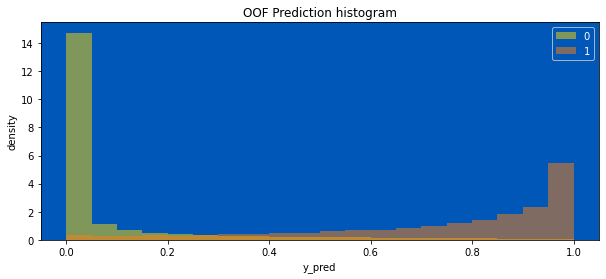

In [11]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

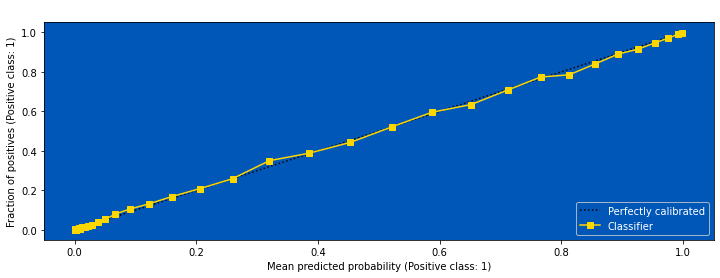

In [12]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()